In [1]:
import jax.numpy as jnp
import jax
import jaxdem as jd
jax.config.update("jax_enable_x64", True)
import numpy as np
import os
from bump_utils import create_clumps
import time
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

W0123 20:17:06.422119 1152339 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0123 20:17:06.424146 1150006 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


In [ ]:
skin = []
mu = []
overflow = []
builds = []
performance = []
radius = []
phi = []
phi_n = []
max_occupancy = []
predicted_max_occupancy = []
nl_cutoff = []

# data_root = '/home/mmccraw/dev/data/26-01-01/grant/neighbor-list-characterization/dynamics'
# data_root = '/home/mmccraw/dev/data/26-01-01/grant/neighbor-list-characterization/dynamics-2'
# data_root = '/home/mmccraw/dev/data/26-01-01/grant/neighbor-list-characterization/dynamics-3'  # over sized
# data_root = '/home/mmccraw/dev/data/26-01-01/grant/neighbor-list-characterization/dynamics-4'  # sized
data_root = '/home/mmccraw/dev/data/26-01-01/grant/neighbor-list-characterization/dynamics-5'  # sized + safety factor 1.2
for name in os.listdir(data_root):
    path = os.path.join(data_root, name)
    try:
        state = jd.utils.h5.load(os.path.join(path, 'state.h5'))
        system = jd.utils.h5.load(os.path.join(path, 'system.h5'))
    except Exception as e:
        print(e)
        continue
    _, _mu, _, _skin = name.split('-')
    mu.append(float(_mu))
    skin.append(float(_skin))
    overflow.append(system.collider.overflow)
    builds.append(system.collider.n_build_times)
    with open(os.path.join(path, 'stats.json'), 'r') as f:
        stats = json.load(f)
    performance.append(state.N * stats['n_steps'] / stats['run_time'])
    radius.append(state.rad.min())
    phi.append(float(jnp.sum(jnp.pi * state.rad ** state.dim * ((1) if state.dim == 2 else (4 / 3))) / jnp.prod(system.domain.box_size)))
    phi_n.append(float(state.N / jnp.prod(system.domain.box_size)))
    max_occupancy.append(jnp.max(jnp.sum(system.collider.neighbor_list != -1, axis=-1)))

    safety_factor = 1.2
    nl_volume = jnp.pi * (safety_factor * float(system.collider.cutoff) * (1.0 + float(_skin))) ** state.dim * ((1) if state.dim == 2 else (4 / 3))
    number_density = float(state.N / jnp.prod(system.domain.box_size))
    occupancy = nl_volume * number_density
    predicted_max_occupancy.append(int(number_density * nl_volume) + 10)
    nl_cutoff.append(float(system.collider.cutoff) * (1.0 + float(_skin)))

    print(jd.utils.thermal.compute_temperature(state, is_rigid=True, subtract_drift=True))

df = pd.DataFrame({
    'skin': skin,
    'mu': mu,
    'overflow': overflow,
    'builds': builds,
    'performance': performance,
    'radius': radius,
    'phi': phi,
    'phi_n': phi_n,
    'max_occupancy': max_occupancy,
    'predicted_max_occupancy': predicted_max_occupancy,
    'nl_cutoff': nl_cutoff,
})

9.063919972007996e-05
9.067676668925207e-05
7.813742856363918e-05
9.101447258046191e-05
8.751024246074688e-05
8.103275469664955e-05
0.0012347930416343868
9.331561258231145e-05
0.00010888607464945826
0.0001020163821334887
9.050774899577738e-05
8.794434221460669e-05
9.471998591269079e-05
8.817717981910053e-05
8.905245003635637e-05
8.593502348148453e-05
0.0003618913975582909
8.999142151322875e-05
9.539695910125583e-05
9.222614801215121e-05
8.818712965274525e-05
8.089287122069176e-05
8.764429230659202e-05
8.680229707583812e-05


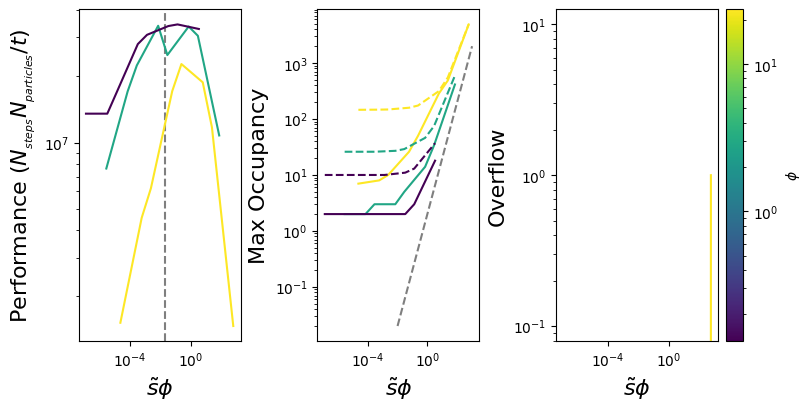

In [21]:
color_mu = False

if color_mu:
    norm = LogNorm(df.mu.min(), df.mu.max())
else:
    norm = LogNorm(df.phi.min(), df.phi.max())
cmap = plt.cm.viridis

fig, ax = plt.subplots(1, 3, figsize=(8, 4), constrained_layout=True)

for mu in df.mu.unique():
    mask = (df.mu == mu)
    _df = df[mask].sort_values(by='skin')
    if color_mu:
        c = cmap(norm(mu))
    else:
        c = cmap(norm(_df.phi.values[0]))
    x = _df.skin ** state.dim * _df.phi
    # x = _df.nl_cutoff ** state.dim * _df.phi_n
    ax[0].plot(x, _df.performance, c=c)
    ax[1].plot(x, _df.max_occupancy, c=c)
    ax[1].plot(x, _df.predicted_max_occupancy, c=c, ls='--')
    ax[2].plot(x, _df.overflow, c=c)

sp = np.logspace(-2, 3, 10)
ax[1].plot(sp, 2 * sp, linestyle='--', color='k', alpha=0.5, zorder=0)

for a in ax:
    a.set_xscale('log')
    a.set_yscale('log')
    a.set_xlabel(r'$\tilde{s} \phi$', fontsize=16)
ax[0].set_ylabel(r'Performance ($N_{_{steps}} N_{_{particles}} / t$)', fontsize=16)
ax[1].set_ylabel('Max Occupancy', fontsize=16)
ax[2].set_ylabel('Overflow', fontsize=16)
ax[0].axvline(2e-2, linestyle='--', color='k', alpha=0.5, zorder=0)

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
if color_mu:
    sm.set_array(np.unique(df.mu))
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')
else:
    sm.set_array(np.unique(df.phi.astype(float)))
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\phi$')

plt.savefig('nl-performance-2d.png')

Array(4.75182931e-08, dtype=float64)